In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')
import warnings
warnings.filterwarnings('ignore')


In [2]:
os.getcwd()
#os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')

'/Users/Grant/Documents/Model Risk Mgmt/MRM-Project'

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd

In [26]:
# Save model dataframe to a pickle file for easier reading
#model_df.to_pickle('model_df.pkl')
model_df = pd.read_pickle('model_df.pkl')

In [29]:
model_df.fully_paid.value_counts()

1    112445
0     28465
Name: fully_paid, dtype: int64

### Downsampling the data to have an even distribution of the target

In [34]:
from sklearn.utils import resample
majority_class = model_df[model_df['fully_paid'] == 1]
minority_class = model_df[model_df['fully_paid'] == 0]

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42 
)

downsampled_model_df = pd.concat([majority_downsampled, minority_class])
downsampled_model_df = downsampled_model_df.sample(frac=1, random_state=42).reset_index(drop=True)
downsampled_model_df.fully_paid.value_counts()

1    28465
0    28465
Name: fully_paid, dtype: int64

In [35]:
X = downsampled_model_df.drop(columns = ['grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d'])
y = downsampled_model_df['fully_paid']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=42)

In [37]:
import optuna
import lightgbm as lgb
import sklearn.metrics

from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, stratify=target)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy, recall

In [38]:
study = optuna.create_study(directions=['maximize','maximize'])
study.optimize(objective, n_trials=100)

[I 2024-11-20 14:41:11,077] A new study created in memory with name: no-name-0af53458-f8c2-43d4-baad-ca5c3dfd2657
[I 2024-11-20 14:41:13,313] Trial 0 finished with values: [0.9012857443968243, 0.8819561551433389] and parameters: {'lambda_l1': 9.731427714469942e-06, 'lambda_l2': 1.7062513042514194e-08, 'num_leaves': 195, 'feature_fraction': 0.8223066506615027, 'bagging_fraction': 0.8429955171975664, 'bagging_freq': 4, 'min_child_samples': 80}.
[I 2024-11-20 14:41:16,116] Trial 1 finished with values: [0.8991077074404553, 0.8857664746381902] and parameters: {'lambda_l1': 0.3472719318871538, 'lambda_l2': 8.240925890034753e-08, 'num_leaves': 203, 'feature_fraction': 0.8554636012325219, 'bagging_fraction': 0.5130298902482077, 'bagging_freq': 3, 'min_child_samples': 57}.
[I 2024-11-20 14:41:18,149] Trial 2 finished with values: [0.8979133000772852, 0.8842046093310849] and parameters: {'lambda_l1': 0.02553402670474049, 'lambda_l2': 9.494269378433623e-05, 'num_leaves': 148, 'feature_fraction':

In [40]:
study.best_trials

[FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.9059931145928476, 0.8899662731871838], datetime_start=datetime.datetime(2024, 11, 20, 14, 41, 42, 207690), datetime_complete=datetime.datetime(2024, 11, 20, 14, 41, 42, 733361), params={'lambda_l1': 2.223364546834443, 'lambda_l2': 1.649432904280486, 'num_leaves': 11, 'feature_fraction': 0.5306603476323929, 'bagging_fraction': 0.8729028811929775, 'bagging_freq': 2, 'min_child_samples': 69}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child

In [47]:
trial = optuna.trial.Trial(study,18)
trial.params

{'lambda_l1': 2.223364546834443,
 'lambda_l2': 1.649432904280486,
 'num_leaves': 11,
 'feature_fraction': 0.5306603476323929,
 'bagging_fraction': 0.8729028811929775,
 'bagging_freq': 2,
 'min_child_samples': 69}

In [45]:
trial_87_params = trial.params

Training accuracy 0.9704
Testing accuracy 0.9007


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

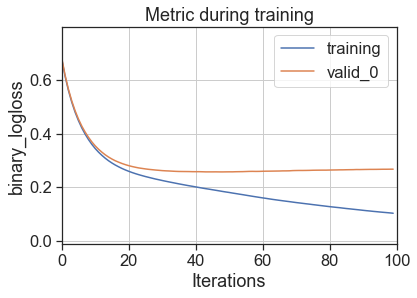

In [48]:
lgbm = lgb.LGBMClassifier(lambda_l1= 2.1422382641914777e-07,
    lambda_l2= 2.2658200484886442e-07,
    num_leaves= 208,
    feature_fraction= 0.8887401691714417,
    bagging_fraction= 0.6009100730937127,
    bagging_freq= 3,
    min_child_samples= 96)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

Training accuracy 0.9083
Testing accuracy 0.9028


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

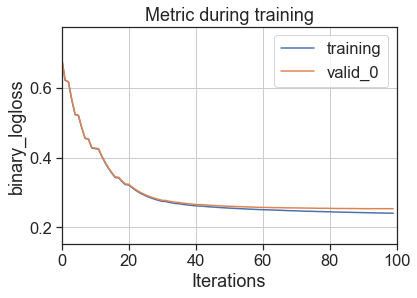

In [50]:
lgbm2 = lgb.LGBMClassifier(lambda_l1= 2.223364546834443,
    lambda_l2= 1.649432904280486,
    num_leaves= 11,
    feature_fraction= 0.5306603476323929,
    bagging_fraction= 0.8729028811929775,
    bagging_freq= 2,
    min_child_samples= 69)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

## LGBM2 performs significantly better than LGBM1 when considering train/test accuracy deltas

In [51]:
os.getcwd()

'/Users/Grant/Documents/Model Risk Mgmt/MRM-Project'